# **Path Planninng for Robots Using Deep Reinforcement Learning**

**Problem description:**

We have a robot that aims to collect data of several low-powered IoT sensors (black circles in the following image). The robot starts its mission from the start terminal (${\color{red}{red}}$ square in the following image). There is a charging station in the environment so that the robot can recharge its battery if it is running out of energy (${\color{green}{green}}$ square).

Also, there are several obstacles in the environment. The task of the robot is to collect data of all sensors in the shortest possible time while it avoids any collision to the obstacles.


In the following image, we have depicted the environment:

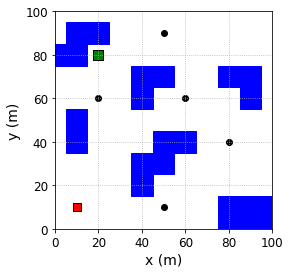

**Required Packages:**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple

import warnings

# warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

## **Environment:**

**Environment parameters:**

First, we define the parameters of the environment. As the robot's task is to collect data of IoT sensors, we need to know the communication channel parameters as well as the data collection reqirements. Below, these parameters are given.  

In [2]:
sigma2 = 10**-14 # noise power
W = 20* (10**6) # channel Bandwidth
T_s = 2 # Duration of each time slot
tau = 0 # Trasmission time of each sensor
P_max = 0.1 # maximum transmit power of each sensor
num_sensors = 5
data_req = (0.4 * 10**9 )* np.ones(num_sensors) # Data: 0.4 GB for each sensor
thr = 10 # threshold distance to the terminal for making decision of the done flag
B0 = 10000000000 # Initial energy level
v = 5 #max velocity of the UAV
H = 10 # Altitude of the UAV
dt = 2

**Environment class:**

In the next section, we define our environment as a class. We have to make sure that the type of the state is numpy ndarray.

In [3]:
class IoT_env(object):
  def __init__(self, num_sensors, initial_position, X_max, Y_max, num_actions):
    #Initial state of the system:
    self.state0 = np.zeros((3,11,11))
    self.state0[0][9][1] = 1 #the UAV position

    self.Obstacle_x = [0 , 1, 1, 1, 1, 2 ,4 ,4 ,4 ,4 ,5, 5, 5, 6, 8,8 ,8 , 9, 9, 9,9, 10, 10]
    self.Obstacle_y = [2, 6, 5, 2,1 , 1, 8,7, 4, 3, 7,6 , 3, 6, 10, 9, 3, 10, 9, 4, 3, 10, 9]

    for i in range(len(self.Obstacle_x)):
      self.state0[1, self.Obstacle_y[i], self.Obstacle_x[i]] = 1

    self.state0[1][1][9] = 1 #the position of the Terminal
    self.state0[1][2][2] = 0.5 # position of the charging station
     
    #position of the noon-complete sensors and the percentage
    self.state0[2][4][2] = 1
    self.state0[2][1][5] = 1
    self.state0[2][9][5] = 1
    self.state0[2][4][6] = 1
    self.state0[2][6][8] = 1
    
    self.sensors_XY = {0:[50.,10.], 1: [20., 60.], 2: [80.,40.], 3: [60.,60.], 4:[50.,90.] }
    self.X_max = X_max #range of X: X_max, the min is 0
    self.Y_max = Y_max #range of Y: Y_max, the min is 0
    self.Collected_Data = np.zeros(num_sensors) # Data collected from each sensor
    self.vector_state0 = np.asarray([10.,10.]) #initial state
    self.Is_Terminal = False
    self.vector_agentState = np.copy(self.vector_state0) # state of the agent
    self.agentState = np.copy(self.state0) # state of the agent
    self.visited_charger = 0


    self.energy_level = B0
    #self.TerminalXY1 = np.asarray([10., 10.]) # terminal 1
    self.Terminal = np.asarray([10., 10.]) #np.asarray([90., 90.]) # terminal 2
    self.doneType = 0 # flag showing type of done!
    self.max_episode_steps = 5000
    self.steps_counter = 0
    self.num_actions = num_actions
    #self.actionspace = {0: [0,0], 1:[v,0], 2:[v,v], 3: [0,v], 4: [-v,v], \
    #                    5:[-v,0], 6:[-v,-v], 7:[0,-v], 8: [v,-v]}
    
    self.actionspace = {0: [0,0], 1:[v,0], 2:[0,v], 3: [-v,0], 4: [0,-v]}
    


  def reset(self):
    self.agentState = np.copy(self.state0)
    self.vector_agentState = np.copy(self.vector_state0)
    self.energy_level = B0
    self.Collected_Data = np.zeros(num_sensors)
    self.doneType = 0
    self.steps_counter = 0
    self.Is_Terminal = False
    self.visited_charger = 0
    return self.agentState



  def step(self, action):
    V = self.actionspace[action]
    self.vector_agentState[0] += V[0] * dt
    self.vector_agentState[1] += V[1] * dt
    if self.vector_agentState[0] < 0:
      self.vector_agentState[0] = 0
    if self.vector_agentState[0] > 100:
      self.vector_agentState[0] = 100
    if self.vector_agentState[1] < 0:
      self.vector_agentState[1] = 0
    if self.vector_agentState[1] > 100:
      self.vector_agentState[1] = 100

    i_x = np.copy(self.vector_agentState[0])/10
    i_y = 10 - np.copy(self.vector_agentState[1])/10
    self.agentState = np.copy(self.state0)
    self.agentState[0][9][1] = 0
    self.agentState[0, int(i_y), int(i_x)] = 1
    self.energy_level -= self.propulsion_power(V) * T_s
    self.steps_counter +=1
    self.Is_Terminal = self.isTerminal()
    
    reward = self.get_reward()

    data_ = np.copy(self.Collected_Data)
    data_normalized = data_ /(data_req[0])
    percentage_data = 1 - data_normalized 
    for i_ in range(len(percentage_data)):
      percentage_data[i_] = max(0,percentage_data[i_])
    
    self.agentState[2][9][5] = (np.digitize(percentage_data[0] ,[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], right =True))/10
    self.agentState[2][4][2] = (np.digitize(percentage_data[1] ,[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], right =True))/10
    self.agentState[2][6][8] = (np.digitize(percentage_data[2] ,[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], right =True))/10
    self.agentState[2][4][6] = (np.digitize(percentage_data[3] ,[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], right =True))/10
    self.agentState[2][1][5] = (np.digitize(percentage_data[4] ,[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], right =True))/10
    
    return self.agentState, reward, self.Is_Terminal , None




  def propulsion_power(self,V):
    v = (np.linalg.norm(V))**0.5
    Pr_power = 79.85 + 0.01663 * (v**2) + 0.009242 * (v**3) + \
      89.44 * (( 1+ ((v**4)/(4.03**4)))**0.5 - (v**2)/(2*(4.03**2)) )**0.5
    return Pr_power

  def isTerminal(self):
    #if self.agentState[2] < 0:
    #  self.doneType = -1
    #  return True 
    Distance2Terminal = np.linalg.norm(np.subtract(self.vector_agentState , self.Terminal))
    #d_ = np.greater(self.agentState[-num_sensors : ] , data_req ) 
    d_ = np.greater(self.Collected_Data , data_req ) 
    if d_.all() == True and Distance2Terminal**0.5 == 0 and self.energy_level > 0: ###self.agentState[2] > 0 :
      self.doneType = 1
      return True
    #elif d_.all() == True and Distance2Terminal_2**0.5 <= 10 and self.agentState[2] > 0 :
      #self.doneType = 2
      #return True
    else:
      return False




  def get_reward(self):
    ch, dist = self.channel()
    reward = 0 
    Indicator_ = np.zeros(num_sensors)

    if self.vector_agentState[0] ==20 and self.vector_agentState[1] == 80 and self.visited_charger ==0:
      self.visited_charger = 1
      #reward = 0
      self.energy_level = 100000000

    i_x = int(np.copy(self.vector_agentState[0])/10)
    i_y = int(10 - np.copy(self.vector_agentState[1])/10)


    for i in range(len(self.Obstacle_x)):
      if self.Obstacle_x[i] == i_x and self.Obstacle_y[i] == i_y:
        #print(1)
        reward = -20





    if not self.Is_Terminal: 
      self.resourceAllocation()
      Distance2Terminal = np.linalg.norm(np.subtract(self.vector_agentState , self.Terminal))

      for i in range(num_sensors):
        if self.Collected_Data[i] - data_req[i] > 0:
          Indicator_[i] = 0
        else:
          Indicator_[i] = 1

      if np.mean(Indicator_) !=0:
        reward += - 5* np.sum(Indicator_)
      else:
        reward += -1
      
      if self.energy_level < 0:
        reward += -100
    
    elif self.doneType == 1:
        reward = 10
    return reward


  def channel(self):
    ch = np.zeros(num_sensors)
    D = np.zeros(num_sensors)
    for i in range(num_sensors):
      D[i] = H**2 + (self.vector_agentState[0] - self.sensors_XY[i][0] )**2 + (self.vector_agentState[1] - self.sensors_XY[i][1] )**2
      ch[i] = (10**-3) / (D[i])
    Distances = D**0.5
    return ch, Distances

  def resourceAllocation(self):
    E = P_max * np.ones(num_sensors)
    channel, Distance = self.channel()
    best_link = np.argmax(channel)
    if (Distance[best_link]) <= thr:
      connected_link = best_link
      p_trans = P_max
      self.Collected_Data[connected_link] += np.log2(1 + (p_trans * channel[connected_link])/(sigma2))\
        * W * T_s * (1-tau)
    

## **DQN Agent:**

In this project, we use a DQN agent to control the robot. In the following, we define our neural network.

**Hyperparameters:**

In [4]:
TARGET_UPDATE = 5
num_episodes = 200
hidden = 128
gamma = 0.99
replay_buffer_size = 100000
batch_size = 128
eps_stop = 0.1
epsilon = 0.6
eps = 0.5
Start_epsilon_decaying = 0
#End_epsilon_decaying = num_episodes // 1
End_epsilon_decaying = 200
epsilon_decaying = epsilon / (End_epsilon_decaying - Start_epsilon_decaying)

**Replay Memory:**

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

**DQN Agent:**

In [6]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim, hidden):
        super(DQN, self).__init__()
        self.hidden = hidden
        self.conv1 = nn.Conv2d(3, 16, 4, 1)
        self.conv2 = nn.Conv2d(16, 32, 4, 1)
        #self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(5*5*32, 64)
        #self.fc2 = nn.Linear(hidden, 64)
        #self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(64, action_space_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.3)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        # x = self.fc2(x)
        # x = F.relu(x)
        x = self.fc4(x)
        return x


class DQNAgent(object):
    def __init__(self, state_space, n_actions, replay_buffer_size,
                 batch_size, hidden_size, gamma):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_actions = n_actions
        self.state_space_dim = state_space
        self.policy_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.memory = ReplayMemory(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

    def update_network(self, updates=1):
        for _ in range(updates):
            self._do_network_update()

    def _do_network_update(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        #print(type(transitions))
        #print(transitions)
        batch = Transition(*zip(*transitions))
        

        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal, s in zip(non_final_mask,
                                                          batch.next_state) if nonfinal > 0]
        #print(non_final_next_states)
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon):
        sample = random.random()
        #print(state)
        #print(state.shape)
        
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
          return random.randrange(self.n_actions)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        #print(next)
        next_state = torch.from_numpy(next_state).float()
        state = torch.from_numpy(state).float()
        self.memory.push(state, action, next_state, reward, done)




## **Training Loop:**

First, let's create the environment and the agent:

In [7]:
n_actions = 5
num_sensors = 5
state_space_dim = 2
starting_position = [10, 10]
env = IoT_env(num_sensors, starting_position, 100, 100, n_actions)

In [8]:
agent = DQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                 hidden, gamma)

**Training:**

number of steps taken by the agent:  3423
episode: 0: reward: -34217.00
**********************************************
episode: 1: reward: -42451.00
**********************************************
number of steps taken by the agent:  2104
episode: 2: reward: -29638.00
**********************************************
number of steps taken by the agent:  477
episode: 3: reward: -5909.00
**********************************************
number of steps taken by the agent:  264
episode: 4: reward: -2846.00
**********************************************
number of steps taken by the agent:  2169
episode: 5: reward: -9654.00
**********************************************
number of steps taken by the agent:  1926
episode: 6: reward: -6481.00
**********************************************
number of steps taken by the agent:  684
episode: 7: reward: -4999.00
**********************************************
number of steps taken by the agent:  252
episode: 8: reward: -1850.00
****************************

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


number of steps taken by the agent:  32
episode: 199: reward: -361.00
**********************************************


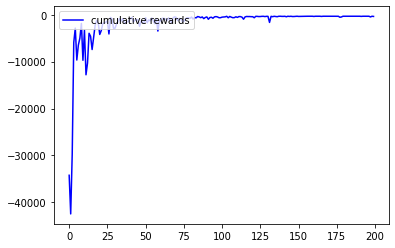

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


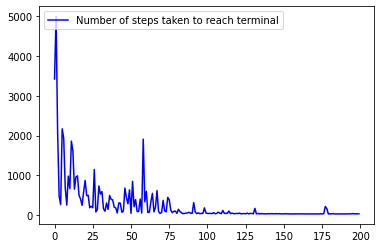

In [9]:
random.seed(20)
env.reset()


# Training loop
cumulative_rewards = []
Num_steps = []
counter_reach_goal = 0
last50_rewards = []
last50_steps = []


for ep in range(num_episodes):
    # Initialize the environment and state
    #print('training started ...')
    Collected_data_time = {0:[], 1:[], 2:[], 3:[], 4:[]}
    state = env.reset()
    done = False
    eps -= epsilon_decaying
    epsilon = max(0.01, eps)
    cum_reward = 0
    counter = 0
    number_of_steps_taken_to_terminal = 0
    #print("episode number: ",ep)
    while not done and counter < env.max_episode_steps:
        # if ep % 100 == 0:
        # env.render()
        # Select and perform an action
        action = agent.get_action(state, epsilon)
        #print(action)
        #action_ = action_dict[action]
        next_state, reward, done, _ = env.step(action)
        #if counter%10 ==0:
        #print(next_state)


        cum_reward += reward
        
        agent.store_transition(state, action, next_state, reward, done)
        agent.update_network()

        state = next_state
        for i_ in range(num_sensors):

          Collected_data_time[i_].append(env.Collected_Data[i_])

        counter +=1
        number_of_steps_taken_to_terminal  += 1
    
 


    #print(state)
    if done:
      #print(state)
      print('number of steps taken by the agent: ', number_of_steps_taken_to_terminal)
    Num_steps.append(number_of_steps_taken_to_terminal)
    ###print(env.agentState[-5:])
    ###print(env.Collected_Data)
    
    ###if env.doneType != 0:
      ###print("Type of Terminal done flag: " ,env.doneType)
    cumulative_rewards.append(cum_reward)
    #if ep >= 50:
    #    last50_rewards.append(np.mean(cumulative_rewards[ep - 50:ep]))
    #    last50_steps.append(np.mean(Num_steps[ep -50: ep]))
    ###print("episode: %d: reward: %6.2f, epsilon: %.2f" % ( ep, cum_reward, epsilon))
    print("episode: %d: reward: %6.2f" % ( ep, cum_reward))
    print("**********************************************")

    # Update the target network, copying all weights and biases in DQN
    if ep % TARGET_UPDATE == 0:
        agent.update_target_network()

# env.close()
plt.plot(range(num_episodes), cumulative_rewards, label='cumulative rewards', color='b')
#plt.plot(range(50,num_episodes), last50_rewards, label='last 50 episodes', color='r')
plt.legend(loc=2)
plt.savefig('R.eps',format = 'eps')
plt.show()


plt.plot(range(num_episodes), Num_steps, label='Number of steps taken to reach terminal', color='b')
#plt.plot(range(50,num_episodes), last50_steps, label='last 50 episodes', color='r')
plt.legend(loc=2)
plt.savefig('S.eps',format = 'eps')
plt.show()



### **Results:**

**Reward:**

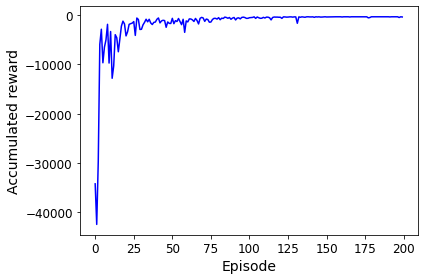

In [10]:
plt.figure(tight_layout=True)
plt.plot(range(num_episodes), cumulative_rewards, label='cumulative rewards', color='b')
plt.xlabel('Episode',size = '14')
plt.ylabel('Accumulated reward', size = '14')
plt.grid(False)
plt.xticks(size = '12')
plt.yticks(size = '12')
#plt.savefig('R_3.eps',format = 'eps')
plt.show()

**Number of steps taken by the agent to collect data of all sensors:**

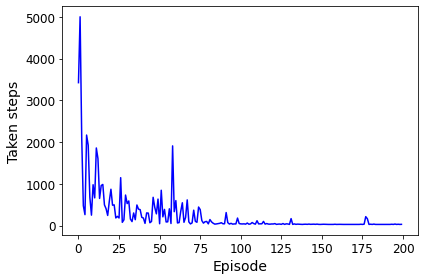

In [11]:
plt.figure(tight_layout=True)
plt.plot(range(num_episodes), Num_steps, color='b')
plt.xlabel('Episode',size = '14')
plt.ylabel('Taken steps', size = '14')
plt.grid(False)
plt.xticks(size = '12')
plt.yticks(size = '12')
plt.savefig('S_3.eps',format = 'eps',dpi=1200)
plt.show()

**The robot's path:**

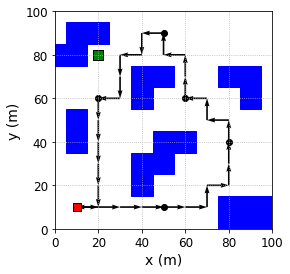

In [13]:
Collected_data_time = {0:[], 1:[], 2:[], 3:[], 4:[]}
state = env.reset()
done = False
cum_reward = 0
counter = 0
number_of_steps_taken_to_terminal = 0
visited_X = []
visited_Y = []

while not done and counter < env.max_episode_steps:
  action = agent.get_action(state, 0.0)
  #print(action)

  visited_X.append(env.vector_agentState[0])
  visited_Y.append(env.vector_agentState[1])

  next_state, reward, done, _ = env.step(action)
  cum_reward += reward
        
  state = next_state
  for i_ in range(num_sensors):
    Collected_data_time[i_].append(env.Collected_Data[i_])

  counter +=1
  number_of_steps_taken_to_terminal  += 1



### Plot the trajectory
x = np.append(np.array(visited_X), env.Terminal[0])
y = np.append(np.array(visited_Y), env.Terminal[1])
x_s = np.array([50, 20, 80, 60, 50 ])
y_s = np.array([10, 60, 40, 60, 90])

x_o = env.Obstacle_x 
y_o = env.Obstacle_y





plt.figure()

plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1)

plt.scatter(x_s, y_s, c = 'k' ,marker = "o",label = 'Sensor')

for i in range(len(x_o)):
    rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), 10, 10, fc='blue',ec="blue")
    plt.gca().add_patch(rectangle)



plt.scatter(10,10, marker = "s", ec = 'k', c ='red', s=50, label ="Terminal")
#plt.scatter(90,90, marker = "s", ec = 'k', c ='red', s =50)
plt.scatter(20,80,marker = "s", ec = 'k', c='green', s=100, label='Charging station')
plt.grid(linestyle=':')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('x (m)',size = '14')
plt.ylabel('y (m)',size = '14')
#plt.legend(loc=4)
plt.xticks(size = '12')
plt.yticks(size = '12')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('T_3.eps',format = 'eps')
plt.show()
####################################





**Collected data from each sensor and the corresponding time:**

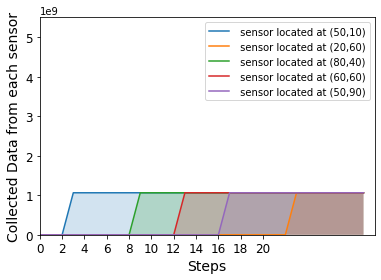

number of steps taken by the agent:  30


In [16]:
plt.figure()
for ii in range(num_sensors):
  plt.plot(range(counter),Collected_data_time[ii], label =' sensor located at ({0:.0f},{1:.0f})'.format(\
              env.sensors_XY[ii][0], env.sensors_XY[ii][1]))
  plt.fill_between(range(counter),Collected_data_time[ii], np.zeros(counter), alpha = 0.2, linewidth=2)
  plt.xlabel('Steps', size = '14')
  plt.ylabel('Collected Data from each sensor', size = '14')
  plt.xlim(0,counter)
  plt.ylim(0, 5.5* 10**9)
  plt.xticks(np.arange(0, 22, step=2), size = '12')
  plt.yticks(size = '12')
  #plt.grid(True)
plt.legend(loc=0, fontsize = 'medium')
#plt.axvline(15,linestyle='dashed')
plt.savefig('C_3.pdf',format = 'pdf')
plt.show()  
   
print('number of steps taken by the agent: ', number_of_steps_taken_to_terminal)
